# 因子回测

## 导入模块

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy import stats
import feather
import os
import statsmodels.api as sm
import sunlandsdatasdk as sd

## 定义回测区间

In [2]:
start_date = '2019-01-01'
end_date = '2025-01-01'

## 读入和处理数据

### 读入 ST 股票

读入全公司列表

In [3]:
issues = feather.read_dataframe('../data/issues.feather')
issues_tot = issues['issue'].sort_values().unique()

读入 ST 股票

In [4]:
# sd.auth('*', '*')
# st = sd.get_st_issue(issues=list(issues_tot), start_date=start_date, end_date=end_date)
# st = st.set_index('date').stack().reset_index().rename(columns={'level_1': 'issue', 0: 'st'})
# feather.write_dataframe(st, '../data/st.feather')
st = feather.read_dataframe('../data/st.feather')

### 读入日线数据

读入日线数据

In [5]:
price_1d = feather.read_dataframe('../data/StockPriceK1d_20241231.feather')

计算调仓日

In [6]:
trade_date = price_1d['date'].sort_values().unique()
mes = pd.date_range(start=start_date, end=end_date, freq='1ME')
adj_date = np.array([], dtype=np.datetime64)
for me in mes:
    trade_date_before = trade_date[trade_date <= me]
    ad = trade_date_before[-1]
    adj_date = np.append(adj_date, ad)
map_mon_adj = {ad.year * 100 + ad.month: ad for ad in adj_date}

计算每两个调仓日之间的收益

In [7]:
price_1d['year_mon'] = price_1d['date'].dt.year * 100 + price_1d['date'].dt.month

def ret_acc_prod(price_1d):
    ret = price_1d['ret']
    return (1 + ret).prod() - 1

def ret_acc(price_1d):
    preclose = price_1d.iloc[0]['preclose']
    close = price_1d.iloc[-1]['close']
    return (close - preclose) / preclose

def ret_acc_adj(price_1d):
    hfq = price_1d['close'] * price_1d['adj']
    return hfq / hfq.shift(1) - 1

def ret_acc_adj_2(price_1d):
    open_hfq = price_1d.iloc[0]['open'] * price_1d.iloc[0]['adj']
    close_hfq = price_1d.iloc[-1]['close'] * price_1d.iloc[-1]['adj']
    return close_hfq / open_hfq - 1

# price_prod = (
#     price_1d[(price_1d['date'] >= start_date) & (price_1d['date'] <= end_date)]
#         .groupby(['issue', 'year_mon'])[['preclose', 'close', 'adj', 'ret']]
#         .apply(ret_acc_prod)
#         .reset_index()
# )

mon_last = (
    price_1d[(price_1d['date'] >= '2018-12-01') & (price_1d['date'] <= end_date)]
        .groupby(['issue', 'year_mon'])
        .last()
)
price_adj = (
    mon_last
        .groupby('issue', group_keys=False)
        .apply(ret_acc_adj)
        .reset_index()
        .dropna()
)

price_adj = price_adj.rename(columns={0: 'ret'})
price_adj['date'] = price_adj['year_mon'].apply(map_mon_adj.get)
price_adj['ret_next'] = price_adj.groupby('issue')['ret'].shift(-1)
price_adj = price_adj[['issue', 'date', 'ret', 'ret_next']]
price_adj = price_adj.dropna(subset='ret_next')

剔除股票

In [8]:
def newly_listed(date, timedelta='180D'):
    start_date = date.min()
    newly = (date <= start_date + pd.Timedelta(timedelta))
    return newly

price_1d['newly_listed'] = (
    price_1d
        .groupby('issue')['date']
        .transform(newly_listed)
)

price_adj = pd.merge(
    price_adj,
    price_1d[['issue', 'date', 'newly_listed', 'is_limit_sell', 'is_limit_buy']],
    on=['issue', 'date'],
    how='left'
)
price_adj = pd.merge(
    price_adj,
    st,
    on=['issue', 'date'],
    how='left'
)
price_adj['st'] = price_adj['st'].ffill()

price_adj = price_adj[
    (~price_adj['newly_listed']) &
    (~price_adj['is_limit_buy'].astype(bool)) &
    (~price_adj['is_limit_sell'].astype(bool))
]
price_adj = price_adj[~price_adj['st']]
price_adj = price_adj[['issue', 'date', 'ret', 'ret_next']]

C:\Users\admin\AppData\Local\Temp\ipykernel_11916\4021416782.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_adj['st'] = price_adj['st'].ffill()


### 计算基准

中证 500

In [9]:
# sd.auth('*', '*')
# index_bar = sd.get_index_bar('000906', start_date='2018-12-01', end_date=end_date)
# index_bar['date'] = pd.to_datetime(index_bar['date'])
# index_bar = index_bar.drop(columns='_id')

# index_bar['year_mon'] = index_bar['date'].dt.year * 100 + index_bar['date'].dt.month
# index_bar = index_bar.groupby('year_mon').last()
# ret_index = index_bar['close'] / index_bar['close'].shift(1) - 1
# ret_index = ret_index.reset_index().dropna().rename(columns={'close': 'ret'})
# ret_index['date'] = ret_index['year_mon'].apply(map_mon_adj.get)
# ret_index['ret_next'] = ret_index['ret'].shift(-1)
# ret_index = ret_index.dropna()
# ret_index = ret_index.set_index('date')

# os.makedirs('../data/benchmark/', exist_ok=True)
# feather.write_dataframe(ret_index, '../data/benchmark/benchmark_000906.feather')
# ret_index

全样本等权

In [10]:
# ret_sample = (
#     price_adj
#         .groupby('date')[['ret', 'ret_next']].mean()
# )
# os.makedirs('../data/benchmark/', exist_ok=True)
# feather.write_dataframe(ret_sample, '../data/benchmark/benchmark_sample.feather')
# ret_sample

## IC 测试

In [11]:
def IC_calc_once(factor, factor_col, ret_col):
    IC, p = stats.spearmanr(factor[factor_col], factor[ret_col])
    return IC

def IC_calc(factor, factor_col):
    f = factor.copy()
    f = pd.merge(
        f,
        price_adj,
        on=['issue', 'date'],
        how='inner'
    )  
    IC = (
        f
            .groupby('date')[[factor_col, 'ret_next']]
            .apply(IC_calc_once, factor_col=factor_col, ret_col='ret_next')
    )
    return IC

## 分组测试

### 计算分组收益和换手率

In [12]:
def grouped_ret(f, factor_col):
    f_date = f.copy()
    qcut = pd.qcut(
        f_date[factor_col],
        q=10,
        labels=np.arange(1, 11)
    )
    f_date['group'] = qcut
    ret = f_date.groupby('group', observed=False)['ret_next'].mean()
    return ret

def top_weight(f, factor_col):
    f_date = f.copy()
    f_date['group'] = pd.qcut(
        f_date[factor_col],
        q=10,
        labels=np.arange(1, 11)
    )
    top = pd.Series(0., index=issues_tot)
    issues_top = f_date.loc[f_date['group'] == 10, 'issue'].to_list()
    top[issues_top] = 1 / len(issues_top)
    return top

def grouped_calc(factor, factor_col, factor_name=None):
    if factor_name == None:
        factor_name = factor_col
    f = pd.merge(
        factor,
        price_adj,
        on=['issue', 'date'],
        how='inner'
    )
    ret = (
        f
            .groupby('date')[[factor_col, 'ret', 'ret_next']]
            .apply(grouped_ret, factor_col=factor_col)
    )
    top = (
        f
            .groupby('date')[[factor_col, 'issue']]
            .apply(top_weight, factor_col=factor_col)
    )
    turnover = np.abs(top - top.shift(1)).sum(axis=1)
    return ret, turnover

### 画分组收益图和多空收益曲线

In [13]:
def grouped_plot(ret, ret_excess, dirname=None):
    ret_annual = (1 + ret.mean()) ** 12 - 1
    # ret_annual = (1 + ret).prod() ** (12 / len(ret)) - 1
    plt.bar(ret_annual.index, ret_annual, color='#a60021')
    plt.xlabel('Group')
    plt.ylabel('Annualized Return')
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    if dirname == None:
        plt.show()
    else:
        os.makedirs(dirname, exist_ok=True)
        plt.savefig(dirname + '/grouped_' + factor_name + '.png')
        plt.close()
    
    long = (1 + ret[10]).cumprod()
    long_excess = (1 + ret_excess[10]).cumprod()
    long_short = (1 + ret[10] - ret[1]).cumprod()
    plt.plot(long, linewidth=3, color='#a60021', label='long')
    plt.plot(long_short, linewidth=3, color='#ffc000', label='long-short')
    ylim = plt.ylim()
    plt.fill_between(
        long_excess.index, 0, long_excess,
        color='#a5a5a5', label='long_excess',
    )
    plt.ylim(ylim)
    plt.legend()
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Net Value')
    if dirname == None:
        plt.show()
    else:
        os.makedirs(dirname, exist_ok=True)
        plt.savefig(dirname + '/nv_' + factor_name + '.png')
        plt.close()

### 计算最大回撤

In [14]:
def max_drawdown_calc(ret):
    cumret = (1 + ret).cumprod()
    running_max = cumret.cummax()
    drawdown = cumret / running_max - 1
    return drawdown.min()

## 一键回测

In [15]:
def backtest(filename, factor_col, factor_name=None, benchmark=None, dirname=None):
    if factor_name == None:
        factor_name = factor_col
    factor = feather.read_dataframe(filename)

    df_IC = pd.DataFrame(columns=['factor', 'IC_mean', 'winning', 'IC_IR', 't', 'max', 'min'])
    IC = IC_calc(factor, factor_col=factor_col)

    sign = np.sign(IC.mean())
    factor[factor_col] *= sign

    winning = (np.sign(IC) == sign).sum() / len(IC)
    df_IC.loc[0] = [
        factor_name,
        winning,
        IC.mean(),
        IC.mean() / IC.std(),
        np.sqrt(len(IC)) * IC.mean() / IC.std(),
        IC.max(),
        IC.min()
    ]

    df_grouped = pd.DataFrame(columns=[
        'factor',
        'long_annual', 'excess_annual', 'long_sharpe',
        'long_short',
        'max_drawdown', 'turnover_annual'
    ])
    grouped, turnover = grouped_calc(
        factor, factor_col=factor_col,
        factor_name=factor_name
    )
    if benchmark != None:
        ret_benchmark = feather.read_dataframe(benchmark)
    ret_benchmark = ret_benchmark.reindex(grouped.index)
    excess = grouped.sub(ret_benchmark['ret_next'], axis=0)
    grouped_plot(grouped, excess)
    long_annual = (1 + grouped[10].mean()) ** 12 - 1
    excess_annual = (1 + excess[10].mean()) ** 12 - 1
    std_annual = np.sqrt(12) * excess[10].std()
    long_short = (1 + (grouped[10] - grouped[1]).mean()) ** 12 - 1
    max_drawdown = max_drawdown_calc(grouped[10] - grouped[1])
    turnover_annual = turnover.mean() * 12
    df_grouped.loc[0]=[
        factor_name,
        long_annual,
        excess_annual,
        excess_annual / std_annual,
        long_short,
        max_drawdown,
        turnover_annual
    ]
    
    return df_IC, df_grouped

## 跳跃收益因子回测

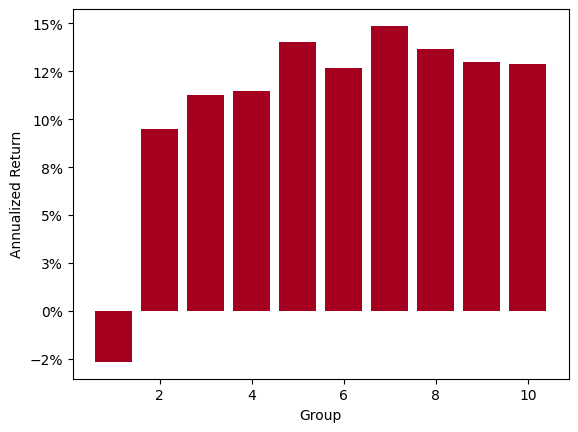

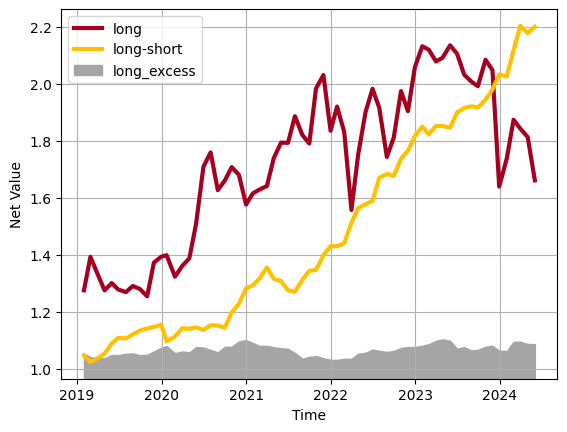

----------ret_jump_neutral----------


,factor,IC_mean,winning,IC_IR,t,max,min
0,ret_jump_neutral,0.815385,-0.045763,-0.900023,-7.256217,0.080992,-0.175871


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,ret_jump_neutral,0.129016,0.016403,0.399035,0.159508,-0.062559,20.46685


In [16]:
# cols = ['ret_jump', 'indus_factor', 'neutral_factor']
# names = ['ret_jump', 'ret_jump_indus', 'ret_jump_neutral']
cols = ['neutral_factor']
names = ['ret_jump_neutral']
for factor_col, factor_name in zip(cols, names):
    IC, grouped = backtest(
        '../data/ret_jump/neutral_ret_jump.feather',
        factor_col=factor_col,
        benchmark='../data/benchmark/benchmark_sample.feather',
        factor_name=factor_name,
        # dirname='../data/ret_jump/backtest1/'
    )
    print('-' * 10 + factor_name + '-' * 10)
    display(IC)
    display(grouped)

## 点度中心性回测

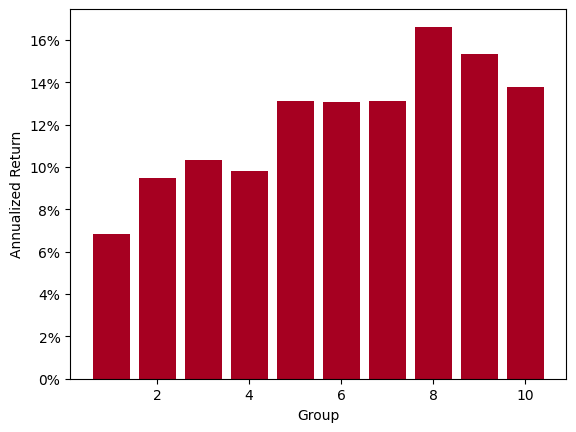

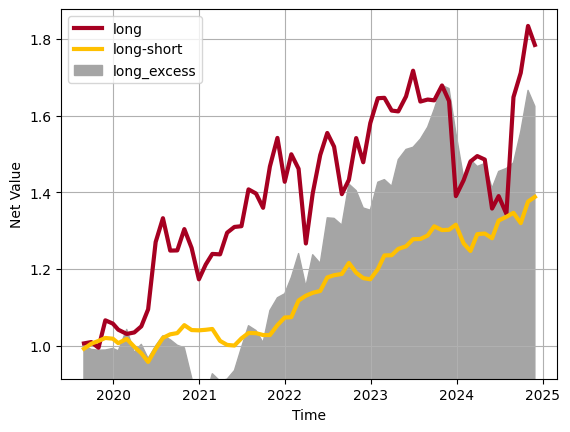

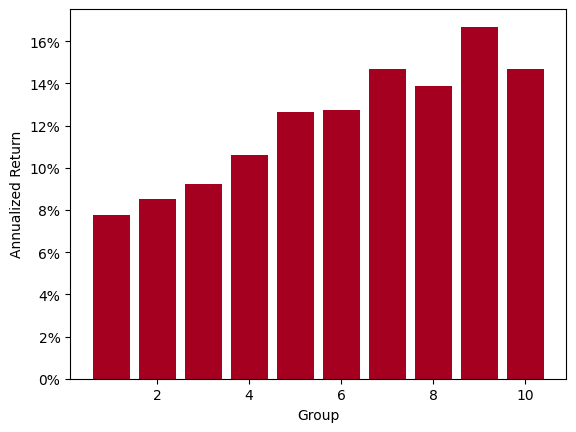

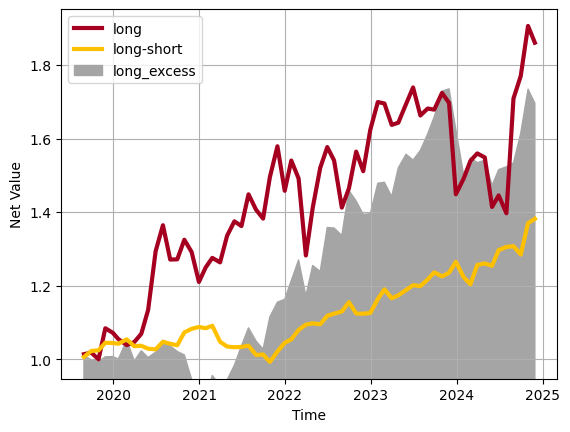

,factor,IC_mean,winning,IC_IR,t,max,min
0,num_neutral,0.828125,0.033435,0.682919,5.463351,0.135539,-0.121017
0,size_neutral,0.828125,0.035143,0.694828,5.558625,0.146744,-0.118299


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,num_neutral,0.137631,0.106164,0.743652,0.065244,-0.061241,11.782436
0,size_neutral,0.146812,0.115112,0.807340,0.064522,-0.090096,9.081106


In [17]:
dirname = '../data/N_connect_0_1/'
filename_num = dirname + '/neutral_N_connect_num.feather'
filename_size = dirname + '/neutral_N_connect_size.feather'
# cols = ['N_connect', 'indus_factor', 'neutral_factor']
# names_num = ['num', 'num_indus', 'num_neutral']
# names_size = ['size', 'size_indus', 'size_neutral']
cols=['neutral_factor']
names_num = ['num_neutral']
names_size = ['size_neutral']
for col, name_num, name_size in zip(cols, names_num, names_size):
    IC_num, grouped_num = backtest(
        filename=filename_num,
        factor_col=col, factor_name=name_num,
        benchmark='../data/benchmark/benchmark_000906.feather',
        # dirname=dirname + '/backtest1/'
    )
    IC_size, grouped_size = backtest(
        filename=filename_size,
        factor_col=col, factor_name=name_size,
        benchmark='../data/benchmark/benchmark_000906.feather',
        # dirname=dirname + '/backtest1/'
    )
    IC = pd.concat([IC_num, IC_size])
    grouped = pd.concat([grouped_num, grouped_size])
    display(IC)
    display(grouped)

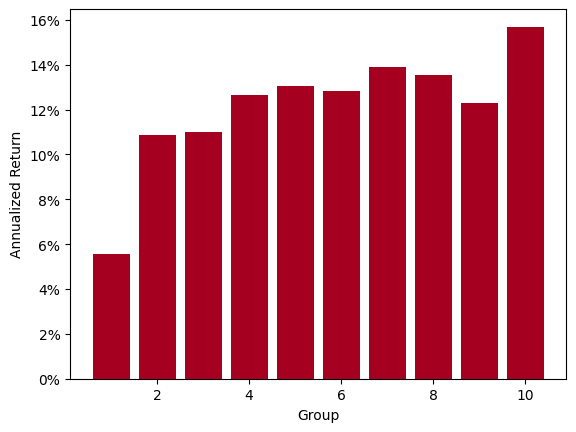

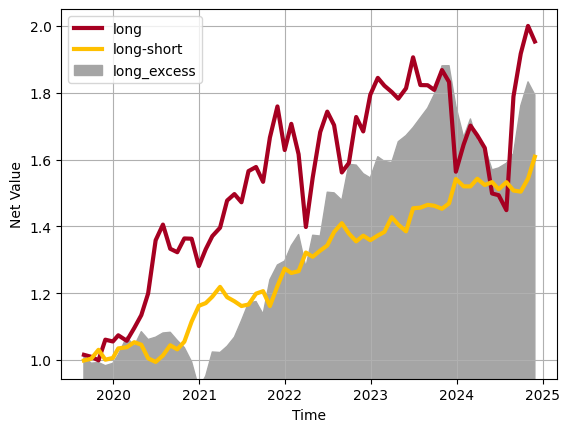

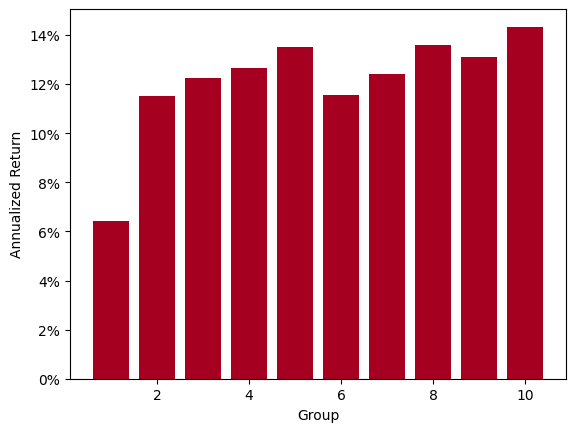

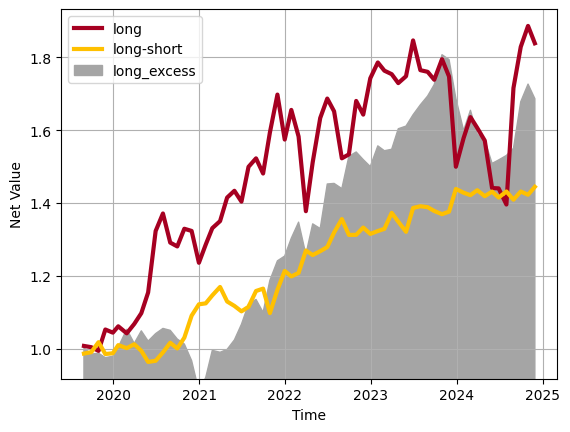

,factor,IC_mean,winning,IC_IR,t,max,min
0,num_neutral,0.625,-0.035074,-0.446364,-3.570912,0.121009,-0.224008
0,size_neutral,0.625,-0.030425,-0.386713,-3.093705,0.133171,-0.199034


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,num_neutral,0.156928,0.124972,0.957801,0.096345,-0.056050,9.569343
0,size_neutral,0.143376,0.111763,0.874273,0.074880,-0.061511,7.894108


In [18]:
dirname = '../data/N_connect_1_any/'
filename_num = dirname + '/neutral_N_connect_num.feather'
filename_size = dirname + '/neutral_N_connect_size.feather'
# cols = ['N_connect', 'indus_factor', 'neutral_factor']
# names_num = ['num', 'num_indus', 'num_neutral']
# names_size = ['size', 'size_indus', 'size_neutral']
cols=['neutral_factor']
names_num = ['num_neutral']
names_size = ['size_neutral']
for col, name_num, name_size in zip(cols, names_num, names_size):
    IC_num, grouped_num = backtest(
        filename=filename_num,
        factor_col=col, factor_name=name_num,
        benchmark='../data/benchmark/benchmark_000906.feather',
        # dirname=dirname + '/backtest1/'
    )
    IC_size, grouped_size = backtest(
        filename=filename_size,
        factor_col=col, factor_name=name_size,
        benchmark='../data/benchmark/benchmark_000906.feather',
        # dirname=dirname + '/backtest1/'
    )
    IC = pd.concat([IC_num, IC_size])
    grouped = pd.concat([grouped_num, grouped_size])
    display(IC)
    display(grouped)

## 跳跃关联动量因子回测

In [19]:
# filename_num = '../data/peer_ret/neutral_peer_ret_num.feather'
# filename_size = '../data/peer_ret/neutral_peer_ret_size.feather'
# IC_num, grouped_num = backtest(filename_num, 'neutral_factor', 'peer_relative_ret_num')
# IC_size, grouped_size = backtest(filename_size, 'neutral_factor', 'peer_relative_ret_size')
# IC = pd.concat([IC_num, IC_size])
# grouped = pd.concat([grouped_num, grouped_size])
# display(IC)
# display(grouped)